# HLoC Camera Pose Estimation Pipeline

This notebook demonstrates camera pose estimation from images/videos using HLoC (Hierarchical Localization) in a dockerized environment.

## Features:
- Process images or videos as input
- Extract features using state-of-the-art extractors (SuperPoint, ALIKED, etc.)
- Match features using various matchers (SuperGlue, LightGlue, etc.)
- Perform Structure-from-Motion (SfM) reconstruction
- Export camera poses for all frames
- Visualize 3D reconstruction and camera poses

In [1]:
# Setup and imports

# If error: prepend the following to hloc/hloc/reconstruction.py
# from __future__ import annotations

%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars

import os
import cv2
import numpy as np
from pathlib import Path
import shutil
from PIL import Image
import json

# Add hloc module to path
import sys
sys.path.append('../modules/hloc')

from hloc import (
    extract_features,
    match_features,
    reconstruction,
    visualization,
    pairs_from_exhaustive,
)
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d
import pycolmap # ignore version warnings from hloc, anything >= 0.6.1 will do fine

[2025/09/18 21:31:31 hloc WARNING] hloc requires pycolmap>=3.12.3 but found pycolmap==0.6.1, please upgrade with `pip install --upgrade "pycolmap>=3.12.3"`


## Configuration

Configure input/output paths and processing parameters.

In [2]:
# Configuration
INPUT_DIR = Path("../videos")  # Can contain videos or image sequences
OUTPUT_DIR = Path("../outputs/hloc_poses")
TEMP_DIR = Path("../temp/hloc_processing")

# Feature extraction and matching configurations
# Available extractors: superpoint, aliked, disk, d2net, r2d2
FEATURE_EXTRACTOR = "superpoint"  # or "aliked-n16"
FEATURE_MATCHER = "superglue"     # or "lightglue", "nearest_neighbor"

# Processing parameters
MAX_IMAGES = 100  # Limit number of frames for processing
FRAME_SKIP = 5    # Extract every N-th frame from videos
RESIZE_MAX = 1024 # Maximum image dimension

# Create directories
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

print(f"Input directory: {INPUT_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Temporary directory: {TEMP_DIR}")
print(f"Feature extractor: {FEATURE_EXTRACTOR}")
print(f"Feature matcher: {FEATURE_MATCHER}")

Input directory: ../videos
Output directory: ../outputs/hloc_poses
Temporary directory: ../temp/hloc_processing
Feature extractor: superpoint
Feature matcher: superglue


## Input Processing

Process input videos and images, extracting frames as needed.

In [3]:
def extract_frames_from_video(video_path, output_dir, frame_skip=5, max_frames=100):
    """Extract frames from video file."""
    cap = cv2.VideoCapture(str(video_path))
    frame_count = 0
    extracted_count = 0
    
    output_dir.mkdir(parents=True, exist_ok=True)
    
    while cap.isOpened() and extracted_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
            
        if frame_count % frame_skip == 0:
            frame_filename = output_dir / f"frame_{extracted_count:06d}.jpg"
            cv2.imwrite(str(frame_filename), frame)
            extracted_count += 1
            
        frame_count += 1
    
    cap.release()
    print(f"Extracted {extracted_count} frames from {video_path.name}")
    return extracted_count

def process_input_files():
    """Process all input files (videos and images)."""
    images_dir = TEMP_DIR / "images"
    images_dir.mkdir(parents=True, exist_ok=True)
    
    video_extensions = {'.mp4', '.avi', '.mov', '.mkv', '.wmv', '.flv', '.webm'}
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}
    
    processed_files = []
    total_images = 0
    
    if not INPUT_DIR.exists():
        print(f"Warning: Input directory {INPUT_DIR} does not exist!")
        return [], 0
    
    for file_path in INPUT_DIR.iterdir():
        if file_path.is_file():
            file_ext = file_path.suffix.lower()
            
            if file_ext in video_extensions:
                print(f"Processing video: {file_path.name}")
                video_output_dir = images_dir / file_path.stem
                frame_count = extract_frames_from_video(
                    file_path, video_output_dir, FRAME_SKIP, MAX_IMAGES
                )
                total_images += frame_count
                processed_files.append((file_path, 'video', frame_count))
                
            elif file_ext in image_extensions:
                print(f"Copying image: {file_path.name}")
                dest_path = images_dir / file_path.name
                shutil.copy2(file_path, dest_path)
                total_images += 1
                processed_files.append((file_path, 'image', 1))
    
    print(f"\nTotal images to process: {total_images}")
    return processed_files, total_images

# Process input files
processed_files, total_image_count = process_input_files()

if total_image_count == 0:
    print("No valid input files found! Please add videos or images to the input directory.")
else:
    print(f"\nProcessed files summary:")
    for file_path, file_type, count in processed_files:
        print(f"  {file_path.name} ({file_type}): {count} frames/images")

Processing video: drone1.mp4
Extracted 100 frames from drone1.mp4

Total images to process: 100

Processed files summary:
  drone1.mp4 (video): 100 frames/images


## Collect and Display Images

Collect all processed images and display a sample.

Found 100 images for processing

Displaying sample of 6 images:

First few image names:
  1: drone1/frame_000000.jpg
  2: drone1/frame_000001.jpg
  3: drone1/frame_000002.jpg
  4: drone1/frame_000003.jpg
  5: drone1/frame_000004.jpg
  6: drone1/frame_000005.jpg
  7: drone1/frame_000006.jpg
  8: drone1/frame_000007.jpg
  9: drone1/frame_000008.jpg
  10: drone1/frame_000009.jpg


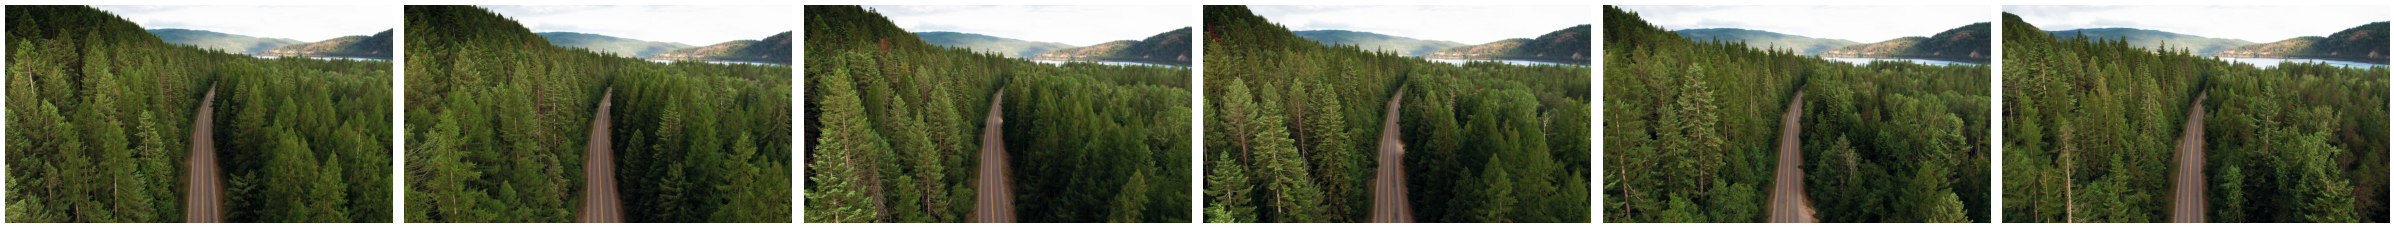

In [4]:
def collect_image_list():
    """Collect all images from the processing directory."""
    images_dir = TEMP_DIR / "images"
    image_list = []
    
    if not images_dir.exists():
        return image_list
    
    # Collect all images from subdirectories and root
    for file_path in images_dir.rglob("*"):
        if file_path.is_file() and file_path.suffix.lower() in {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}:
            # Convert to relative path from images_dir
            rel_path = file_path.relative_to(images_dir)
            image_list.append(rel_path.as_posix())
    
    image_list.sort()
    return image_list

# Collect images
images_base = TEMP_DIR / "images"
image_list = collect_image_list()

print(f"Found {len(image_list)} images for processing")

if len(image_list) > 0:
    # Display a sample of images
    sample_size = min(6, len(image_list))
    sample_indices = np.linspace(0, len(image_list)-1, sample_size, dtype=int)
    sample_images = [read_image(images_base / image_list[i]) for i in sample_indices]
    
    print(f"\nDisplaying sample of {sample_size} images:")
    plot_images(sample_images, dpi=50)
    
    print(f"\nFirst few image names:")
    for i, img_name in enumerate(image_list[:10]):
        print(f"  {i+1}: {img_name}")
else:
    print("No images found for processing!")

## Feature Extraction and Matching

Extract features from all images and match them.

In [ ]:
if len(image_list) == 0:
    print("Skipping feature extraction - no images available")
else:
    # Set up output paths
    sfm_pairs = OUTPUT_DIR / "pairs-sfm.txt"
    features = OUTPUT_DIR / "features.h5"
    matches = OUTPUT_DIR / "matches.h5"
    
    # Configure feature extractor and matcher
    feature_conf = extract_features.confs["superpoint_aachen"]  # Use available config
    if FEATURE_MATCHER == "superglue":
        matcher_conf = match_features.confs["superglue"]
    elif FEATURE_EXTRACTOR.startswith("aliked") and FEATURE_MATCHER == "lightglue":
        matcher_conf = match_features.confs["aliked+lightglue"]
    else:
        matcher_conf = match_features.confs["nearest_neighbor"]
    
    print(f"Feature extraction configuration: {feature_conf}")
    print(f"Matching configuration: {matcher_conf}")
    
    # Extract features
    print("\nExtracting features...")
    extract_features.main(
        feature_conf, images_base, image_list=image_list, feature_path=features
    )
    
    # Generate image pairs (exhaustive for smaller datasets)
    print("\nGenerating image pairs...")
    pairs_from_exhaustive.main(sfm_pairs, image_list=image_list)
    
    # Match features
    print("\nMatching features...")
    match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches)
    
    print("\nFeature extraction and matching completed!")

[2025/09/18 21:31:54 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}


Feature extraction configuration: {'output': 'feats-superpoint-n4096-r1024', 'model': {'name': 'superpoint', 'nms_radius': 3, 'max_keypoints': 4096}, 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
Matching configuration: {'output': 'matches-superglue', 'model': {'name': 'superglue', 'weights': 'outdoor', 'sinkhorn_iterations': 50}}

Extracting features...


[2025/09/18 21:31:55 hloc INFO] Skipping the extraction.
[2025/09/18 21:31:55 hloc INFO] Found 4950 pairs.
[2025/09/18 21:31:55 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}



Generating image pairs...

Matching features...


/app/notebooks/../modules/hloc/hloc/matchers/../../third_party/SuperGluePretrainedNetwork/models/superglue.py:226: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_st

Loaded SuperGlue model ("outdoor" weights)


  0%|          | 0/4950 [00:00<?, ?it/s]

## Structure-from-Motion Reconstruction

Perform 3D reconstruction to estimate camera poses.

In [ ]:
if len(image_list) == 0:
    print("Skipping SfM reconstruction - no images available")
else:
    # Set up SfM output directory
    sfm_dir = OUTPUT_DIR / "sfm"
    
    print("Running Structure-from-Motion reconstruction...")
    
    # Run SfM reconstruction
    model = reconstruction.main(
        sfm_dir, images_base, sfm_pairs, features, matches, image_list=image_list
    )
    
    print(f"\nReconstruction completed!")
    print(f"Number of registered images: {len(model.images)}")
    print(f"Number of 3D points: {len(model.points3D)}")
    print(f"Number of cameras: {len(model.cameras)}")
    
    # Visualize the reconstruction
    print("\nVisualizing 3D reconstruction...")
    fig = viz_3d.init_figure()
    viz_3d.plot_reconstruction(
        fig, model, color="rgba(255,0,0,0.5)", name="reconstruction", points_rgb=True
    )
    fig.show()

## Extract and Export Camera Poses

Extract camera poses for all reconstructed frames and export in various formats.

In [ ]:
def export_camera_poses(model, output_dir):
    """Export camera poses in multiple formats."""
    poses_dir = output_dir / "poses"
    poses_dir.mkdir(parents=True, exist_ok=True)
    
    # Collect camera poses
    camera_poses = []
    
    for image_id, image in model.images.items():
        # Get camera pose (world-to-camera transform)
        cam_from_world = image.cam_from_world
        
        # Convert to camera-to-world (more intuitive)
        world_from_cam = cam_from_world.inverse()
        
        # Extract rotation and translation
        rotation_matrix = world_from_cam.rotation.matrix()
        translation = world_from_cam.translation
        
        # Convert rotation matrix to quaternion (w, x, y, z)
        quaternion = world_from_cam.rotation.quaternion()  # [w, x, y, z]
        
        pose_data = {
            'image_id': image_id,
            'image_name': image.name,
            'camera_id': image.camera_id,
            'translation': translation.tolist(),
            'rotation_matrix': rotation_matrix.tolist(),
            'quaternion': quaternion.tolist(),  # [w, x, y, z]
            'num_points3D': len(image.points3D_ids),
        }
        
        camera_poses.append(pose_data)
    
    # Sort by image name for consistent ordering
    camera_poses.sort(key=lambda x: x['image_name'])
    
    # Export as JSON
    json_file = poses_dir / "camera_poses.json"
    with open(json_file, 'w') as f:
        json.dump(camera_poses, f, indent=2)
    print(f"Exported poses to JSON: {json_file}")
    
    # Export in TUM format (timestamp tx ty tz qx qy qz qw)
    tum_file = poses_dir / "trajectory_tum.txt"
    with open(tum_file, 'w') as f:
        f.write("# TUM trajectory format\n")
        f.write("# timestamp tx ty tz qx qy qz qw\n")
        for i, pose in enumerate(camera_poses):
            tx, ty, tz = pose['translation']
            qw, qx, qy, qz = pose['quaternion']
            f.write(f"{i:06d} {tx:.6f} {ty:.6f} {tz:.6f} {qx:.6f} {qy:.6f} {qz:.6f} {qw:.6f}\n")
    print(f"Exported poses in TUM format: {tum_file}")
    
    # Export in COLMAP format (more detailed)
    colmap_file = poses_dir / "images_poses.txt"
    with open(colmap_file, 'w') as f:
        f.write("# COLMAP image poses\n")
        f.write("# IMAGE_ID, QW, QX, QY, QZ, TX, TY, TZ, CAMERA_ID, NAME, POINTS2D\n")
        for pose in camera_poses:
            qw, qx, qy, qz = pose['quaternion']
            tx, ty, tz = pose['translation']
            f.write(f"{pose['image_id']} {qw:.6f} {qx:.6f} {qy:.6f} {qz:.6f} ")
            f.write(f"{tx:.6f} {ty:.6f} {tz:.6f} {pose['camera_id']} {pose['image_name']}\n")
    print(f"Exported poses in COLMAP format: {colmap_file}")
    
    return camera_poses

if len(image_list) == 0 or 'model' not in locals():
    print("Skipping pose export - no reconstruction available")
else:
    print("Extracting and exporting camera poses...")
    camera_poses = export_camera_poses(model, OUTPUT_DIR)
    
    print(f"\nExported {len(camera_poses)} camera poses")
    
    # Display summary
    print("\nCamera poses summary:")
    for i, pose in enumerate(camera_poses[:5]):  # Show first 5
        tx, ty, tz = pose['translation']
        print(f"  {pose['image_name']}: position=({tx:.3f}, {ty:.3f}, {tz:.3f})")
    
    if len(camera_poses) > 5:
        print(f"  ... and {len(camera_poses) - 5} more")

## Visualization and Analysis

Visualize camera poses and provide analysis of the reconstruction.

In [ ]:
if len(image_list) == 0 or 'model' not in locals():
    print("Skipping visualization - no reconstruction available")
else:
    # Visualize 2D features and matches
    print("Visualizing feature matches...")
    if len(model.images) >= 2:
        visualization.visualize_sfm_2d(model, images_base, color_by="visibility", n=3)
    
    # Camera trajectory analysis
    if 'camera_poses' in locals() and len(camera_poses) > 1:
        print("\nCamera trajectory analysis:")
        
        # Calculate trajectory statistics
        positions = np.array([pose['translation'] for pose in camera_poses])
        
        # Trajectory length
        distances = np.sqrt(np.sum(np.diff(positions, axis=0)**2, axis=1))
        total_distance = np.sum(distances)
        
        # Bounding box
        min_pos = np.min(positions, axis=0)
        max_pos = np.max(positions, axis=0)
        bbox_size = max_pos - min_pos
        
        print(f"  Total trajectory length: {total_distance:.3f} units")
        print(f"  Average step size: {np.mean(distances):.3f} units")
        print(f"  Scene bounding box: {bbox_size[0]:.3f} x {bbox_size[1]:.3f} x {bbox_size[2]:.3f}")
        print(f"  Center position: ({np.mean(positions, axis=0)})")
        
        # Plot camera trajectory in 3D
        fig_traj = viz_3d.init_figure()
        
        # Plot camera positions as a trajectory
        viz_3d.plot_points(fig_traj, positions, color="blue", ps=3, name="camera_positions")
        
        # Plot trajectory line
        import plotly.graph_objects as go
        fig_traj.add_trace(go.Scatter3d(
            x=positions[:, 0],
            y=positions[:, 1], 
            z=positions[:, 2],
            mode='lines',
            name='trajectory',
            line=dict(color='red', width=3)
        ))
        
        fig_traj.update_layout(title="Camera Trajectory")
        fig_traj.show()
    
    print("\nProcessing completed!")
    print(f"Results saved to: {OUTPUT_DIR}")
    print(f"  - 3D reconstruction: {OUTPUT_DIR / 'sfm'}")
    print(f"  - Camera poses: {OUTPUT_DIR / 'poses'}")
    print(f"  - Features and matches: {OUTPUT_DIR}")

## Summary and Output

Summary of processing results and output file locations.

In [ ]:
# Final summary
print("=" * 60)
print("HLoC CAMERA POSE ESTIMATION PIPELINE - SUMMARY")
print("=" * 60)

if len(image_list) > 0 and 'model' in locals():
    print(f"✓ Successfully processed {len(image_list)} input images")
    print(f"✓ Reconstructed {len(model.images)} camera poses")
    print(f"✓ Generated {len(model.points3D)} 3D points")
    print(f"✓ Used {len(model.cameras)} camera model(s)")
    
    reconstruction_rate = len(model.images) / len(image_list) * 100
    print(f"✓ Reconstruction success rate: {reconstruction_rate:.1f}%")
    
    print("\nOutput files:")
    print(f"  📁 Main output directory: {OUTPUT_DIR}")
    print(f"  📄 Camera poses (JSON): poses/camera_poses.json")
    print(f"  📄 Trajectory (TUM): poses/trajectory_tum.txt")
    print(f"  📄 COLMAP poses: poses/images_poses.txt")
    print(f"  📁 3D reconstruction: sfm/")
    print(f"  📄 Features: features.h5")
    print(f"  📄 Matches: matches.h5")
    
else:
    print("❌ No valid input images found or processing failed")
    print(f"   Please check that {INPUT_DIR} contains video files or images")
    print("   Supported video formats: .mp4, .avi, .mov, .mkv, .wmv, .flv, .webm")
    print("   Supported image formats: .jpg, .jpeg, .png, .bmp, .tiff, .tif")

print("\n" + "=" * 60)
print("Pipeline execution completed!")
print("=" * 60)